In [1]:
import final_metric
import config
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data = data.sample(frac=1, random_state=7).reset_index(drop=True)
    data = data.head(config.NUM_SAMPLES)
    data['binary_target'] = data.target.apply(lambda x: 1 if x > 0.5 else 0)
    return data

In [3]:
def preprocess(text_data):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    return vectorizer.fit_transform(text_data)

In [4]:
def train_models(data, test_size=0.2, random_state=42):
    df_train, df_valid = train_test_split(
        data, test_size=test_size, random_state=random_state)

    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

    X_train = df_train["comment_preprocessed"]
    X_valid = df_valid["comment_preprocessed"]
    # vectorize the X data
    X_train = preprocess(df_train["comment_preprocessed"].astype(str))
    X_valid = preprocess(df_valid["comment_preprocessed"].astype(str))

    y_train = df_train["binary_target"]
    y_valid = df_valid["binary_target"]

    models = [
        LogisticRegression(max_iter=1000),
        MultinomialNB(),
        MLPClassifier(),
        LinearSVC(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        RandomForestClassifier()
    ]
    model_names = [
        'Logistic Regression',
        'Naive Bayes',
        'MLP',
        'Linear SVC',
        'Decision Tree',
        'KNeighbors',
        'Random Forest'
    ]

    best_auc = 0
    best_model = None
    best_model_name = None
    best_y_pred = None

    for model, name in zip(models, model_names):
        print(f'Training {name}...')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        auc = roc_auc_score(y_valid, y_pred)
        print(f'{name} AUC: {auc}')
        
        # make final metric call and print it
        metric_value = final_metric.get_value(df_valid, y_pred, name)
        print(metric_value)

        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_model_name = name
            best_y_pred = y_pred

    print(f'Best model: {best_model_name} with AUC: {best_auc}')
    with open(f'models/supervised_model.bin', 'wb') as f:
        pickle.dump(best_model, f)
    
     # add confusion matrix 
    plt.figure(figsize=(10, 8))
    mat = confusion_matrix(y_valid, best_y_pred)
    plt.title(f"Confusion Matrix for {best_model_name}")
    sns.heatmap(mat, square=True, annot=True,cmap="OrRd")
    plt.xlabel('Predicted value')
    plt.ylabel('Actual value');
    
    # add auc plot
    fpr, tpr, thr = roc_curve(y_valid, best_model.predict_proba(X_valid)[:,1])
    auc = roc_auc_score(y_valid, best_y_pred)
    lw = 2
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='#FC5A50', lw=lw, label="Curve Area = %0.3f" % auc)
    plt.plot([0, 1], [0, 1], color='#EE8262', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Plot for {best_model_name}')
    plt.legend(loc="lower right")
    plt.show()



Training Logistic Regression...
Logistic Regression AUC: 0.5021660867956104

---------- Model Performance: Logistic Regression ----------

                        subgroup  subgroup_size  subgroup_auc  bpsn_auc  bnsp_auc
2      homosexual_gay_or_lesbian             55      0.500000  0.502646  0.499743
3                      christian            189      0.500000  0.502762  0.499726
4                         jewish             32      0.500000  0.502591  0.499746
5                         muslim            112      0.500000  0.502857  0.499738
6                          black             81      0.500000  0.502841  0.499742
7                          white            131      0.500000  0.502857  0.499735
8  psychiatric_or_mental_illness             25      0.500000  0.502577  0.499747
1                         female            265      0.513992  0.497863  0.516129
0                           male            201      0.520833  0.500000  0.520558
Final Metric: 0.5027812424346211
0.502781

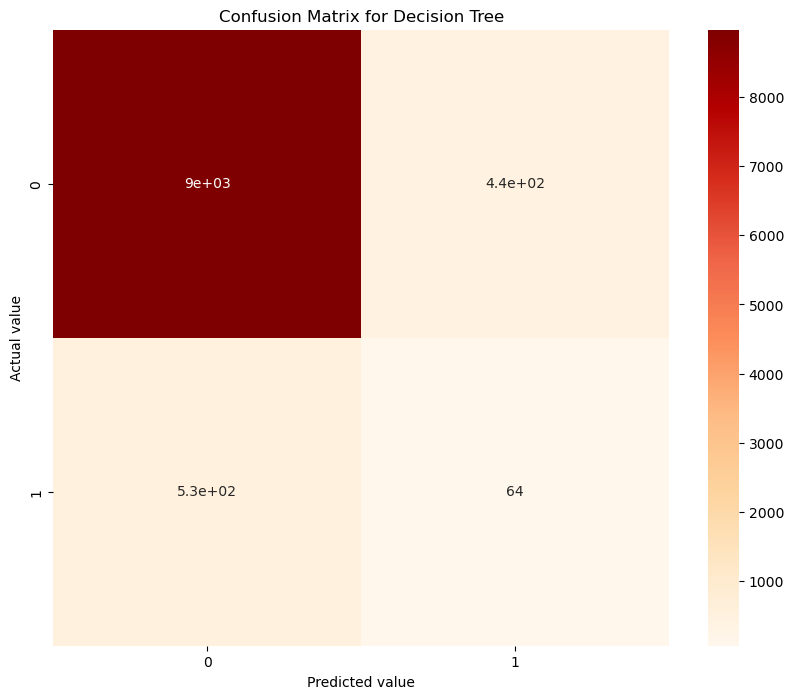

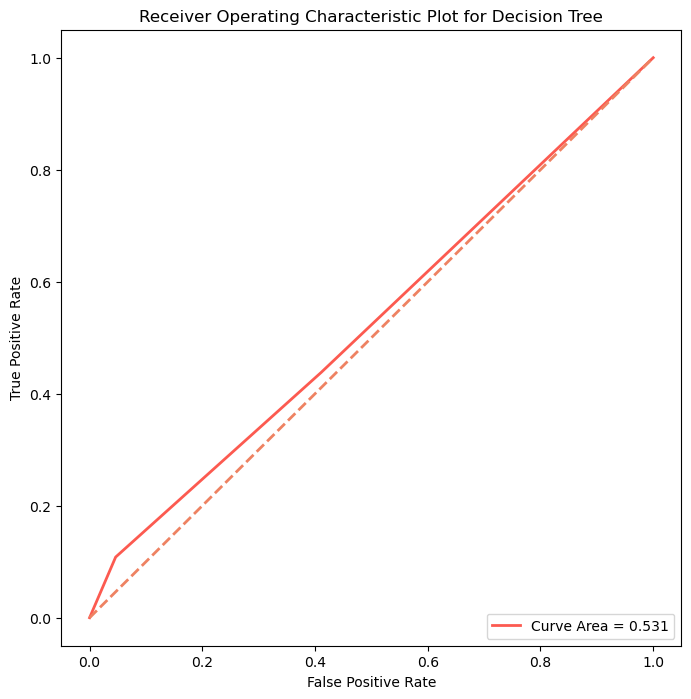

In [5]:
if __name__ == '__main__':
    data = load_data('data/train_comment_preprocessed.csv')

    train_models(data)